# Test path integrator RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import motion

## Define RNN model

In [2]:
class PathRNN(torch.nn.Module):
    
    def __init__(self, n_units):

        super(PathRNN, self).__init__()

        self.n_units = n_units

        # RNN Layer
        self.rnn = torch.nn.RNN(input_size=2, hidden_size=n_units, num_layers=1, nonlinearity='tanh', batch_first=True)

        # Output layer
        self.output = torch.nn.Linear(n_units, 2)
    
    def forward(self, vel):
        
        # Run RNN on velocity sequences to get hidden unit values
        u_vals, _ = self.rnn(vel)
        
        # Apply output weights to get estimated position
        pos_est = self.output(u_vals)
        
        return pos_est, u_vals

## Generate simulated trajectories

In [3]:
sim = motion.MotionSimulation(500, 20)
sim.run()

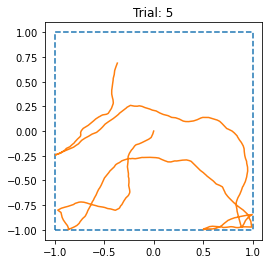

In [4]:
trial_plt = 5

fig, ax = plt.subplots(1, 1)
sim.plot_position(5)
ax.set_title(f'Trial: {trial_plt}');

## Train RNN on trajectory data

In [5]:
# Move data into PyTorch tensors
vel = torch.from_numpy(sim.vel).float()
pos = torch.from_numpy(sim.pos).float()

# Instantiate model
model = PathRNN(n_units=100)

# Define hyperparameters
n_epochs = 100
lr=0.01

# Define Loss, Optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [6]:
# Training Run
for epoch in range(1, n_epochs + 1):

    # Clear gradients from previous epoch
    optimizer.zero_grad()

    # Compute loss
    pos_est, u_vals = model(vel)
    loss = criterion(pos_est, pos)

    # Compute gradient via backprop
    loss.backward()

    # Update model parameters
    optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/100............. Loss: 0.3437
Epoch: 20/100............. Loss: 0.3456
Epoch: 30/100............. Loss: 0.4062
Epoch: 40/100............. Loss: 0.3631
Epoch: 50/100............. Loss: 0.3456
Epoch: 60/100............. Loss: 0.3398
Epoch: 70/100............. Loss: 0.3389
Epoch: 80/100............. Loss: 0.3389
Epoch: 90/100............. Loss: 0.3383
Epoch: 100/100............. Loss: 0.3375


## Compare predicted motion to ground truth

In [7]:
pos_est_plt = pos_est.detach().numpy()

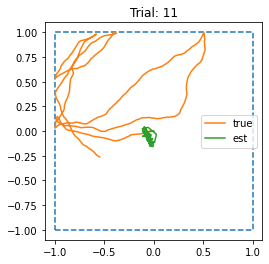

In [11]:
trial_plt = 11

fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
ax.set_title(f'Trial: {trial_plt}')

motion.plot_position_estimate(sim.boundary, sim.pos[trial_plt], pos_est_plt[trial_plt], ax)